# Project resolution of optical dataset onto microwave dataset

## Load data

Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import rioxarray
import xarray
import rasterio
import gdal
import tqdm

#import sklearn

%matplotlib inline

File paths

In [6]:
#mw_path = r"../Data/microwave-rs/CumJour-North-ssmi-1979-2022-H19.nc"
opt_path = r"../Data/optical-rs/2019-07-03_grain_diameter.tif"
mw_path_tif = r"../Data/microwave-rs/mw-tif/2019-07-03_mw.tif"

Import single files

In [7]:
# dataset_mw = xarray.open_dataset(mw_path).rio.write_crs(
#         "epsg:3413", inplace=True
#     )  # add EPSG
# dataset_mw = dataset_mw.where(
#         dataset_mw["time"] == np.datetime64("2019-06-08"), drop=True
#     )  # only use one day for now
# data_mw = dataset_mw["melt"]

data_mw_tif = xarray.open_dataarray(mw_path_tif)
data_opt = xarray.open_dataarray(opt_path)

In [8]:
type(data_mw_tif)

xarray.core.dataarray.DataArray

In [9]:
# In new script:
# data_mw.rio.to_raster("data_mw.tif")
# data_omw_tif = xarray.open_dataarray("data_mw.tif")

In [10]:
def print_raster(raster):
    print(
        f"shape: \n   Y: {raster.rio.shape[0]} \n   X: {raster.rio.shape[1]}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: \n   minx = {raster.rio.bounds()[0]} \n   miny = {raster.rio.bounds()[1]} \n   maxx = {raster.rio.bounds()[2]} \n   maxy = {raster.rio.bounds()[3]}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [11]:
# prepare data - shift here before all?

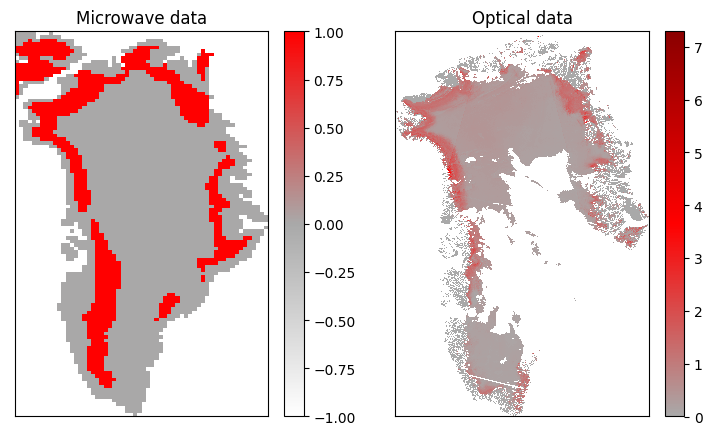

In [18]:
#import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","darkgray","red"])
#cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkgray","red", "gold", 'yellow', "greenyellow"])
# cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkgray", "orangered", "red", "firebrick", "darkred", "maroon"])
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkgray",  "red", "darkred"])


fig, axes = plt.subplots(ncols=2, figsize=(9,5))
data_mw_tif.plot(ax=axes[0], cmap = cmap)
data_opt.plot(ax=axes[1], cmap = cmap2)# cmap2

axes[0].set_title('Microwave data')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[1].set_title('Optical data')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

cbar_0 = axes[0].collections[0].colorbar
cbar_0.set_label('')
cbar_1 = axes[1].collections[0].colorbar
cbar_1.set_label('')

#plt.savefig('20190703_mw_and_opt_plot.pdf')
plt.draw()

## Manually change resolution

1. shift +-500
2. crop optical dataset
3. create empty matrix with cropped optical dataset shape
4. update values:
    - get coordinates for each pixel from opt
    - get values for each coordinate from old 
    - update values in opt copy

In [7]:
# data_mw = xarray.open_dataset(mw_path).rio.write_crs("epsg:3413", inplace=True) # add EPSG
# data_mw = data_mw.where(data_mw["time"] == np.datetime64('2019-06-08'), drop=True)["melt"] # only use one day for now
# data_opt = xarray.open_dataarray(opt_path)

# data_mw.rio.to_raster( 'data_mw_tif.tif')
# data_omv_tif = xarray.open_dataarray('data_mw_tif.tif')

### 1. Shift

In [8]:
data_mw_tif['x'] = [i+500 for i in data_mw_tif['x']]
data_mw_tif['y'] = [i-500 for i in data_mw_tif['y']]

In [10]:
print('OPtical')
print_raster(data_opt)
print('MICROWAVE')
print_raster(data_mw_tif)


OPtical
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 339758.65625
CRS: EPSG:3413

MICROWAVE
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662000.0 
   miny = -3338000.0 
   maxx = 838000.0 
   maxy = -613000.0
sum: -1906.0
CRS: EPSG:3413



### 2. Crop optical dataset

In [11]:
cut_maxx= min(data_mw_tif.rio.bounds()[2], data_opt.rio.bounds()[2])
cut_miny= max(data_mw_tif.rio.bounds()[1], data_opt.rio.bounds()[1])
cut_minx= max(data_mw_tif.rio.bounds()[0], data_opt.rio.bounds()[0])
cut_maxy= min(data_mw_tif.rio.bounds()[3], data_opt.rio.bounds()[3])

In [13]:
# more paths needed
opt_path_out = r"../Data/optical-rs/optical-cropped/"

In [14]:
# cut optical
overlap_window = (cut_minx,cut_maxy,cut_maxx,cut_miny)
gdal.Translate(opt_path_out + 'data_opt_cropped.tif', opt_path, projWin = overlap_window)


data_opt_cropped = xarray.open_dataarray(opt_path_out + 'data_opt_cropped.tif')
print_raster(data_opt_cropped)

shape: 
   Y: 2676 
   X: 1475
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3338000.0 
   maxx = 838000.0 
   maxy = -662000.0
sum: 339758.6875
CRS: EPSG:3413



### 3. Create empty matrix with cropped optical dataset shape

In [15]:
zeros = np.zeros(data_opt_cropped.shape[1:]) # (2, 2)) # data_opt

### 4. update values:
    - get coordinates for each pixel from opt
    - get values for each coordinate from old 
    - update values in opt copy

In [ ]:
with rasterio.open(data_mw_tif) as src_mw:
    with rasterio.open(opt_path) as src_opt:
        trans_opt = src_opt.transform
        data_opt_meta = src_opt.meta
        print(data_opt_meta)
        for row in tqdm(range(data_opt.shape[1])): # 2):#
            for col in tqdm(range(data_opt.shape[2])): # 2):#
                # get coord from optical:
                lon, lat = rasterio.transform.xy(trans_opt,row,col,offset='center') # maybe use upscaled mw 
                # get value from mw dataset:
                val = list(src_mw.sample([(lon, lat)]))[0][0]
                # write values to matrix:
                zeros[row][col] = val
                #print(val)
# 315 min

In [46]:
# save that matrix just in case
#np.isnan(np.min(zeros))
zeros[np.isnan(zeros)] = -1
np.savetxt('mw_val_matrix2.csv', zeros, fmt="%d", delimiter=",")

In [57]:
zeros.min()

-1.0

In [65]:
# Write to TIFF
kwargs = data_opt_meta
kwargs.update(
    dtype=rasterio.float32,
    count=1
    #,compress='lzw'
    ) # transform same?

In [66]:
with rasterio.open('out_new_band2.tif', 'w', **kwargs) as dst:  # how do you open sth that does not exist?
    dst.write_band(1, zeros.astype(rasterio.float32))

In [46]:
data_mw_fine2= xarray.open_dataarray('out_new_band2.tif')

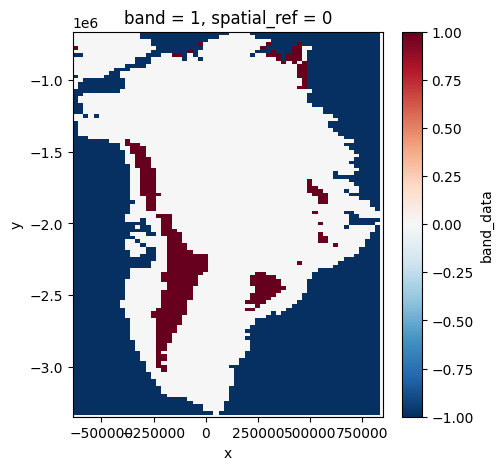

In [69]:
fig, axes = plt.subplots(ncols=1, figsize=(5,5))
data_mw_fine2.plot(ax=axes)
#data_opt.plot(ax=axes[1])
plt.draw()

## Reproject/ resample using rasterio

### Resampling (Nina)

#### Project resolution of optical dataset onto microwave dataset

**ToDo**

- shift pixels/ coordinates (+- 500 to each value)
- check several pixels if corners match
- need to figure out if bounds are universal for all pictures or have to bet individually which might be a paaain

- dataset.transform is the transformation function
- get pixels with transform function
- use Vedran's code
- 

In [ ]:
mw_path = r"../Data/microwave-rs/CumJour-North-ssmi-1979-2022-H19.nc"
opt_path = r"../Data/optical-rs/2019-06-08_grain_diameter.tif"

In [ ]:
dataset_mw = xarray.open_dataset(mw_path).rio.write_crs(
    "epsg:3413", inplace=True
)  # add EPSG
dataset_mw = dataset_mw.where(
    dataset_mw["time"] == np.datetime64("2019-06-08"), drop=True
)  # only use one day for now
data_mw = dataset_mw["melt"]
data_opt = xarray.open_dataarray(opt_path)

In [ ]:
data_mw.rio.to_raster("data_mw.tif")
data_omw_tif = xarray.open_dataarray("data_mw.tif")
data_omw_tif

<xarray.DataArray 'band_data' (band: 1, y: 109, x: 60)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 8e+05 8.25e+05
  * y            (y) float64 -6.25e+05 -6.5e+05 ... -3.3e+06 -3.325e+06
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Surface melt

In [ ]:
print("Microwave TIF Raster:\n----------------")
print_raster(data_omw_tif)
print("Optical Raster:\n----------------")
print_raster(data_opt)

Microwave TIF Raster:
----------------
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662500.0 
   miny = -3337500.0 
   maxx = 837500.0 
   maxy = -612500.0
sum: 358.0
CRS: EPSG:3413

Optical Raster:
----------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413



In [ ]:
with rasterio.open("data_mw.tif") as src_mw:
    with rasterio.open(opt_path) as src_opt:
        opt_tif = src_opt.read(1)
        mw_tif = src_mw.read(1)
        upscaled_mw = np.zeros(opt_tif.shape)
        for row, col in np.argwhere(~np.isnan(mw_tif)):
            lon, lat = rasterio.transform.xy(
                src_mw.transform, row, col, offset="center"
            )
            row_temp, col_temp = rasterio.transform.rowcol(src_opt.transform, lon, lat)
            upscaled_mw[row_temp, col_temp] = 1

In [ ]:
from rasterio.enums import Resampling

upscale_factor = 25
new_width = data_mw.rio.width * upscale_factor
new_height = data_mw.rio.height * upscale_factor

data_mw_upsampled = data_mw.rio.reproject(
    data_mw.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

del data_mw_upsampled.attrs["grid_mapping"]
data_mw_upsampled.rio.to_raster("data_mw_upsampled.tif")

c:\Users\ninaz\anaconda3\envs\my-env\lib\site-packages\rioxarray\raster_writer.py:115: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [ ]:
with rasterio.open("data_mw_upsampled.tif") as src_mw_upsampled:
    with rasterio.open("data_mw.tif") as src_mw:
        with rasterio.open(opt_path) as src_opt:
            upscaled_mw = np.zeros(src_mw_upsampled.shape)
            data_mw_full = xarray.open_dataset(mw_path).rio.write_crs(
                "epsg:3413", inplace=True
            )  # add EPSG
            for row, col in np.argwhere(~np.isnan(src_mw.read(1))):
                lon, lat = rasterio.transform.xy(
                    src_mw.transform, row, col, offset="center"
                )
                # bound= rasterio.transform.array_bounds(row, col,src_mw.transform)
                print(lon, lat)

                # row_new, col_new = rasterio.transform.rowcol(src_mw_upsampled.transform,lon,lat)
                # print(row, col, lon, lat)
            #    print(row, col, lon, lat)

-650000.0 -625000.0
-625000.0 -625000.0
-600000.0 -625000.0
-575000.0 -625000.0
-550000.0 -625000.0
-450000.0 -625000.0
-650000.0 -650000.0
-625000.0 -650000.0
-600000.0 -650000.0
-575000.0 -650000.0
-550000.0 -650000.0
-500000.0 -650000.0
-475000.0 -650000.0
-450000.0 -650000.0
-425000.0 -650000.0
-400000.0 -650000.0
-650000.0 -675000.0
-625000.0 -675000.0
-600000.0 -675000.0
-575000.0 -675000.0
-550000.0 -675000.0
-525000.0 -675000.0
-500000.0 -675000.0
-475000.0 -675000.0
-450000.0 -675000.0
-425000.0 -675000.0
-400000.0 -675000.0
-375000.0 -675000.0
-350000.0 -675000.0
-325000.0 -675000.0
125000.0 -675000.0
150000.0 -675000.0
175000.0 -675000.0
200000.0 -675000.0
-650000.0 -700000.0
-625000.0 -700000.0
-600000.0 -700000.0
-575000.0 -700000.0
-550000.0 -700000.0
-525000.0 -700000.0
-500000.0 -700000.0
-475000.0 -700000.0
-450000.0 -700000.0
-425000.0 -700000.0
-400000.0 -700000.0
-375000.0 -700000.0
-350000.0 -700000.0
-325000.0 -700000.0
75000.0 -700000.0
100000.0 -700000.0
125000.

### Vedran's code

In [ ]:
# VEDRANS CODE
"""
# manually upscale facebook data to same resolution
upscaled_fb = np.zeros(fb_resampled.shape)
for row, col in np.argwhere(fb > 0):
    # find lat long of the original point in the original raster
    lon, lat = rasterio.transform.xy(raster_trans,row,col,offset='center')
    # find the row col of the GPS point in the new reference system
    row, col = rasterio.transform.rowcol(resample_transform,lon,lat)
    # fill in the cell on the new raster
    #upscaled_fb[row,col] = 1
"""

### Change resolution through rio.reproject_match

#### (Nina's) Overlay of microwave and optical remote sensing dataset

Both datasets are projected onto the same coordinate systems
- Input coordinate system for X and Y (EPSG: 3413): WGS 84 / NSIDC Sea Ice Polar Stereographic North
- Output coordinate system for long and lat (EPSG: 4468): Cartesian 2D CS for north polar azimuthal lonO 45°W. Axes: X,Y. Orientations: X along 45°E, Y along 135°E meridians. UoM: m.

Useful links:
- info about ESG:3413: https://epsg.io/3413
- info about EPSG:4468: https://epsg.io/4468-cs
- UI to play around with CRS coordinates: https://epsg.io/map#srs=3413&x=944379.792439&y=-944379.792439&z=2&layer=streets

**Tasks:**
1. overlay
2. analyse and look at thresholds -> compare, do boundaries based on melting (0.64) threshold
3. boudaries for plot? # https://rasterio.readthedocs.io/en/latest/topics/plotting.html

Load data

In [ ]:
mw_path = r"..\Data\microwave-rs\CumJour-North-ssmi-1979-2022-H19.nc"
opt_path = r"../Data/optical-rs/2019-06-08_grain_diameter.tif"

In [ ]:
data_mw = xarray.open_dataset(mw_path).rio.write_crs("epsg:3413", inplace=True) # add EPSG
data_mw = data_mw.where(data_mw["time"] == np.datetime64('2019-06-08'), drop=True)["melt"] # only use one day for now
data_opt = xarray.open_dataarray(opt_path)

Compare both datasets (only using 2019-06-08 for now)

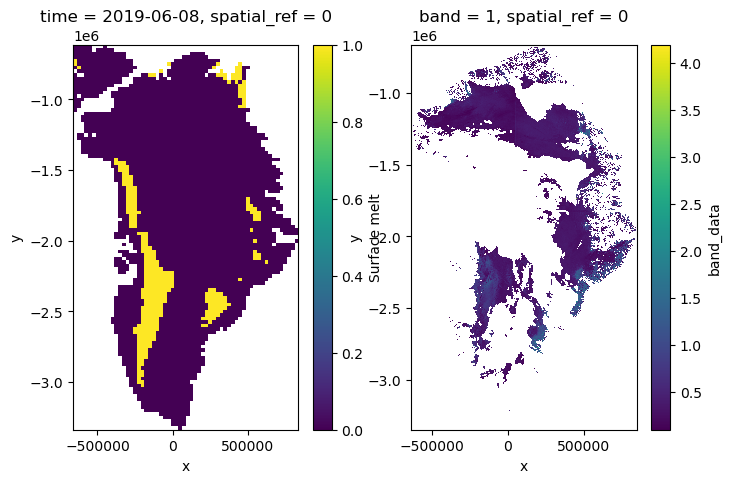

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5))
data_mw.plot(ax=axes[0])
data_opt.plot(ax=axes[1])
plt.draw()

In [ ]:
print("Microwave Raster:\n----------------")
print_raster(data_mw)
print("Optical Raster:\n----------------")
print_raster(data_opt)

Microwave Raster:
----------------
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662500.0 
   miny = -3337500.0 
   maxx = 837500.0 
   maxy = -612500.0
sum: 358.0
CRS: EPSG:3413

Optical Raster:
----------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413



Reproject microwave dataset match the resolution, projection, and region of  optical dataset

In [ ]:
data_repr_mw = data_opt.rio.reproject_match(data_mw)

print("Reprojected Raster:\n-------------------")
print_raster(data_repr_mw)

Reprojected Raster:
-------------------
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662500.0 
   miny = -3337500.0 
   maxx = 837500.0 
   maxy = -612500.0
sum: 535.418212890625
CRS: EPSG:3413



In [ ]:
data_repr_mw

<xarray.DataArray 'band_data' (band: 1, y: 109, x: 60)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 8e+05 8.25e+05
  * y            (y) float64 -6.25e+05 -6.5e+05 ... -3.3e+06 -3.325e+06
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area

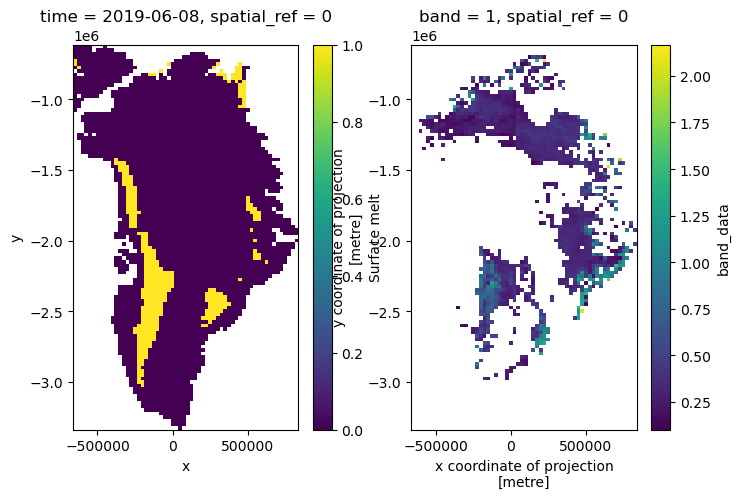

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5))
data_mw.plot(ax=axes[0])
data_repr_mw.plot(ax=axes[1])
plt.draw()

Sum up band of reprojected data and microwave data

In [ ]:
data_repr_mw = data_repr_mw.assign_coords({
    "x": data_mw.x,
    "y": data_mw.y,
})
data_sum = data_repr_mw + data_mw

In [ ]:
print("Sum Raster:\n-----------")
print_raster(data_sum)

Sum Raster:
-----------
shape: 
   Y: 109 
   X: 60
resolution: (25000.0, -25000.0)
bounds: 
   minx = -662500.0 
   miny = -3337500.0 
   maxx = 837500.0 
   maxy = -612500.0
sum: 674.22021484375
CRS: EPSG:3413



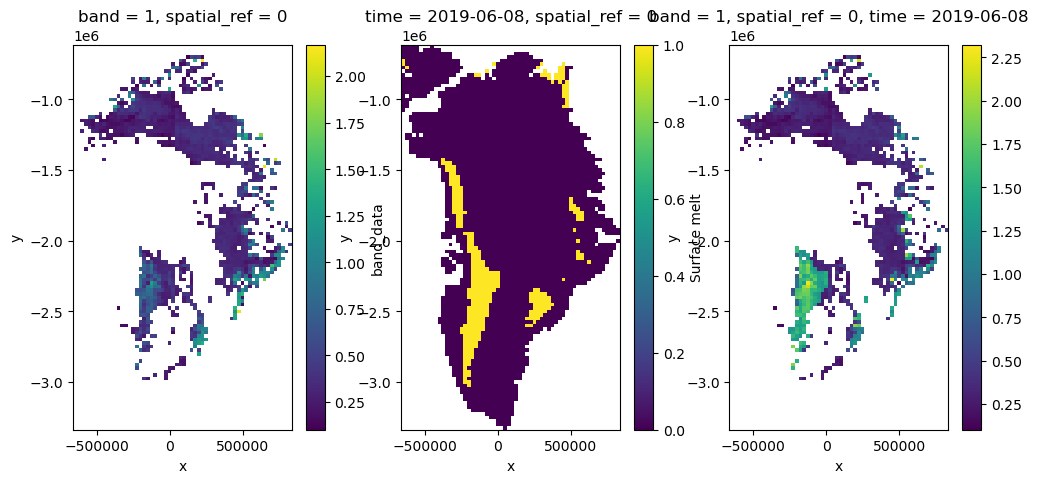

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(12,5))

data_repr_mw.plot(ax=axes[0])
data_mw.plot(ax=axes[1])
data_sum.plot(ax=axes[2])

plt.draw()

The brighter the color in the right plot, the more accordance regarding melting between both datasets

#### (L)

look at metadata and min max before reprojecting

In [7]:
print('OPT')
with rasterio.open(opt_path) as src_opt:
        print(src_opt.meta)
        tt= src_opt.read()
        print(f'min:{tt.min()}')
        print(f'max:{tt.max()}')

print('---------------------------------------------------------')
print('MW')
with rasterio.open(mw_path_tif) as src_mw:
        print(src_mw.meta)
        mw = src_mw.read()
        print(f'min:{mw.min()}')
        print(f'max:{mw.max()}') 


# In new script:
        #np.nan_to_num(mw, nan=-1, copy= False) # inplace 
        #kwargs1 = src_mw.meta.copy()

# # overwrite mw with fixed band
# with rasterio.open('data_mw.tif', 'w', **kwargs1) as dst:
#     dst.write_band(1, mw[0])

OPT
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1487, 'height': 2687, 'count': 1, 'crs': CRS.from_epsg(3413), 'transform': Affine(1000.0, 0.0, -637000.0,
       0.0, -1000.0, -662000.0)}
min:-3.4028234663852886e+38
max:4.195837497711182
---------------------------------------------------------
MW
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 60, 'height': 109, 'count': 1, 'crs': CRS.from_epsg(3413), 'transform': Affine(25000.0, 0.0, -662500.0,
       0.0, -25000.0, -612500.0)}
min:-1.0
max:1.0


In [8]:
# temp
np.unique(data_mw_tif)

array([-1.,  0.,  1.], dtype=float32)

In [9]:
# figure out if this is needed
# check if done before in manual
data_mw_tif['x'] = [i+500 for i in data_mw_tif['x']]
data_mw_tif['y'] = [i-500 for i in data_mw_tif['y']]
# maybe no need bc rio.reproject_match will reproject to match the resolution, projection, AND REGION of another raster.

##### Reprojection:

In [10]:
data_repr_mw = data_mw_tif.rio.reproject_match(data_opt) # raster to match in parenth - try make mw to opt resolution (but not scale so opt scale shouldn't impact?)

#print("Reprojected Raster:\n-------------------")
#print_raster(data_repr_mw)

In [11]:
np.unique(data_repr_mw)

array([-1.0000000e+00,  0.0000000e+00,  1.0000000e+00,  3.4028235e+38],
      dtype=float32)

In [12]:
max_val = data_repr_mw.max() # weird new big new value

#data_repr_mw = np.where(data_repr_mw==max_val, 2, data_repr_mw) # bad bc turns to normal array
#data_repr_mw = xarray.DataArray.where(data_repr_mw!=max_val, other = 2, drop = True) # doesn't work
data_repr_mw = xarray.where(data_repr_mw!=max_val, data_repr_mw,  2)

In [13]:
np.unique(data_repr_mw)

array([-1.,  0.,  1.,  2.], dtype=float32)

In [14]:
print("Compare opt and reprojected datasets \n")

print("reprojected:\n----------------")
print_raster(data_repr_mw)
print("opt:\n----------------")
print_raster(data_opt)

compare opt and reprojected datasets 

reprojected:
----------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: -980562.0
CRS: None

opt:
----------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413



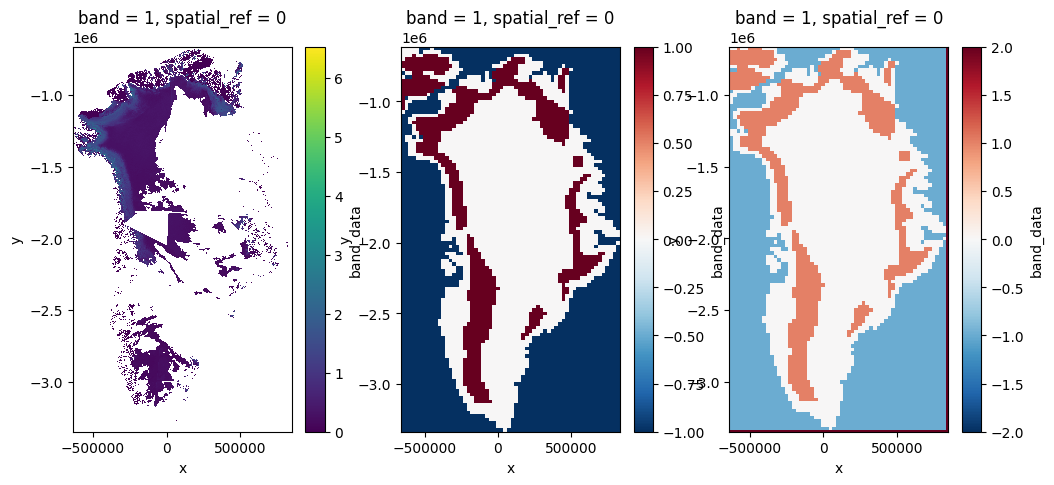

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(12,5))
data_opt.plot(ax=axes[0])
data_mw_tif.plot(ax=axes[1])
data_repr_mw.plot(ax=axes[2])
plt.draw()

In [ ]:
# write to folder? -> mw reprojected ( only in pipeline)

### Change resolution through transform - FAILED
code from here to be ignored for now

1. higher resolution optical

In [ ]:
# check current resolution
print_raster(data_opt) 

shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413



In [ ]:
# rasterio's transform attribute https://rasterio.readthedocs.io/en/latest/quickstart.html

from rasterio.enums import Resampling

image = r"../Data/optical-rs/2019-06-08_grain_diameter.tif"
upscale_factor = 2

with rasterio.open(image) as dataset:

    # resample data to target shape using upscale_factor
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

   
    # print('Shape before resample:', dataset.shape)
    # print('Shape after resample:', data.shape[1:])

    # scale image transform
    dst_transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )B

    # print('Transform before resample:\n', dataset.transform, '\n')
    # print('Transform after resample:\n', dst_transform)

    ## Write outputs
    # set properties for output

    #rasterio.warp.reproject(    )

    dst_kwargs = dataset.meta.copy()
    dst_kwargs.update(
        {
            "transform": dst_transform,
            "width": data.shape[-1],
            "height": data.shape[-2],
            #"nodata": 0,  
        }
    )


Shape before resample: (2687, 1487)
Shape after resample: (5374, 2974)
Transform before resample:
 | 1000.00, 0.00,-637000.00|
| 0.00,-1000.00,-662000.00|
| 0.00, 0.00, 1.00| 

Transform after resample:
 | 500.00, 0.00,-637000.00|
| 0.00,-500.00,-662000.00|
| 0.00, 0.00, 1.00|


In [ ]:
with rasterio.open("temp-2019-06-08_grain_diameter.tif", "w", **dst_kwargs) as dst:
    # iterate through bands
    for i in range(data.shape[0]):
            dst.write(data[i].astype(rasterio.uint32), i+1)

In [ ]:
# open above rewritten array
data_opt_temp = xarray.open_dataarray("temp-2019-06-08_grain_diameter.tif")

In [ ]:
data_opt_temp[0]
# whyy these values and not nan same as before?

<xarray.DataArray 'band_data' (y: 5374, x: 2974)>
array([[2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       ...,
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09],
       [2.147484e+09, 2.147484e+09, 2.147484e+09, ..., 2.147484e+09,
        2.147484e+09, 2.147484e+09]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -6.368e+05 -6.362e+05 ... 8.492e+05 8.498e+05
  * y            (y) float64 -6.622e+05 -6.628e+05 ... -3.348e+06 -3.349e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area

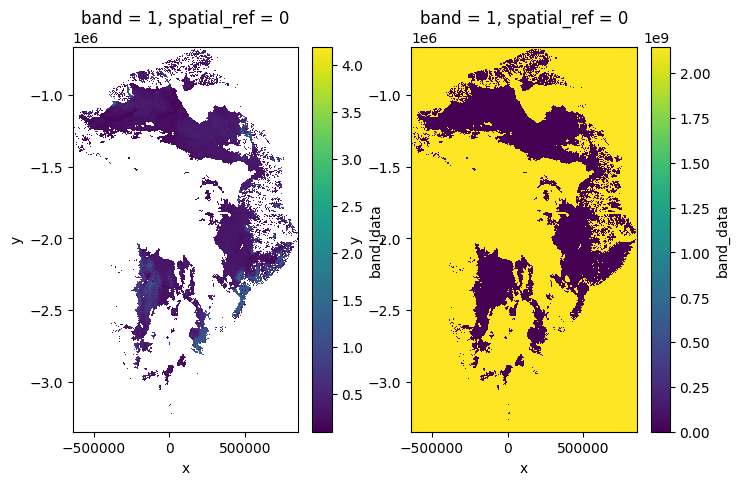

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5))
data_opt.plot(ax=axes[0])
data_opt_temp.plot(ax=axes[1])
plt.draw()

In [ ]:
# seems to have lost a lot of information

# figure out what went wrong:
# looks like inverted and lost gray gradient
# maybe rasterize intead of writing??

#### Inspect errors from above transformation:

In [ ]:
print('ORIG:')
print_raster(data_opt) 
print('NEW:')
print_raster(data_opt_temp) 

ORIG:
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 324417.8125
CRS: EPSG:3413

NEW:
shape: 
   Y: 5374 
   X: 2974
resolution: (500.0, -500.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 2.6907128295849984e+16
CRS: EPSG:3413



In [ ]:
with rasterio.open(image) as dataset:

    # resample data to target shape using upscale_factor
    data1 = dataset.read()

In [ ]:
data1.shape # (1, 2687, 1487)
data.shape #(1, 5374, 2974)

(1, 2687, 1487)

In [ ]:
np.unique(data) # 2974

array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.6269281e+00,  3.6706243e+00,  3.9512947e+00], dtype=float32)

In [ ]:
np.unique(data1) # size 1487

array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.7645121e+00,  3.9512947e+00,  4.1958375e+00], dtype=float32)

In [ ]:
band_id = 1  

raster = rasterio.open(opt_path) #,masked=True)
band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)


print(band_arr.shape)
np.unique(band_arr)

(2687, 1487)


array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.7645121e+00,  3.9512947e+00,  4.1958375e+00], dtype=float32)

In [ ]:
band_id = 1  

raster = rasterio.open("temp-2019-06-08_grain_diameter.tif") #,masked=True)
band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)


print(band_arr.shape)
np.unique(band_arr)

(5374, 2974)


array([0.0000000e+00, 1.0000000e+00, 2.0000000e+00, 3.0000000e+00,
       2.1474836e+09], dtype=float32)

In [ ]:
# shape_ = 1487, 2687
# test_transform = rasterio.transform.from_bounds(*data_opt.rio.bounds(), *shape_) # west, south, east, north, width, height

## xarray.interp() method

In [ ]:
# https://docs.xarray.dev/en/stable/user-guide/interpolation.html#example
# method = "nearest"

# dsi = ds.interp(lat=new_lat, lon=new_lon)

# new lon and lat - every pixel x and y from optical (cut and shifted?)

In [6]:
# cut and write - from manual

# cut_maxx= min(data_mw_tif.rio.bounds()[2], data_opt.rio.bounds()[2])
# cut_miny= max(data_mw_tif.rio.bounds()[1], data_opt.rio.bounds()[1])
# cut_minx= max(data_mw_tif.rio.bounds()[0], data_opt.rio.bounds()[0])
# cut_maxy= min(data_mw_tif.rio.bounds()[3], data_opt.rio.bounds()[3])

# more paths needed
opt_path_out = r"../Data/optical-rs/optical-cropped/"

# cut optical
#overlap_window = (cut_minx,cut_maxy,cut_maxx,cut_miny)
#gdal.Translate(opt_path_out + 'data_opt_cropped.tif', opt_path, projWin = overlap_window)


data_opt_cropped = xarray.open_dataarray(opt_path_out + 'data_opt_cropped.tif')
#print_raster(data_opt_cropped)

In [10]:
data_mw_tif = xarray.open_dataarray(mw_path_tif)
data_opt = xarray.open_dataarray(opt_path)

In [11]:
mw_path = r"../Data/microwave-rs/CumJour-North-ssmi-1979-2022-H19.nc"


dataset_mw = xarray.open_dataset(mw_path).rio.write_crs(
        "epsg:3413", inplace=True
    )  # add EPSG
dataset_mw = dataset_mw.where(
        dataset_mw["time"] == np.datetime64("2019-06-08"), drop=True
    )  # only use one day for now
data_mw = dataset_mw["melt"]

In [12]:
mw_path_tif = r"../Data/microwave-rs/mw-tif/2019-07-01_mw.tif"
data_mw_tif = xarray.open_dataarray(mw_path_tif)


In [13]:
test1 = data_mw.interp(x=data_opt['x'], y=data_opt['y'] , method="nearest")

In [ ]:
# take x from cut opt

In [27]:
test2 = data_mw_tif.interp(x=data_opt['x'], y=data_opt['y'] , method="nearest")

In [14]:
test3 = data_mw_tif.interp(x=data_opt_cropped['x'], y=data_opt_cropped['y'] , method="nearest")

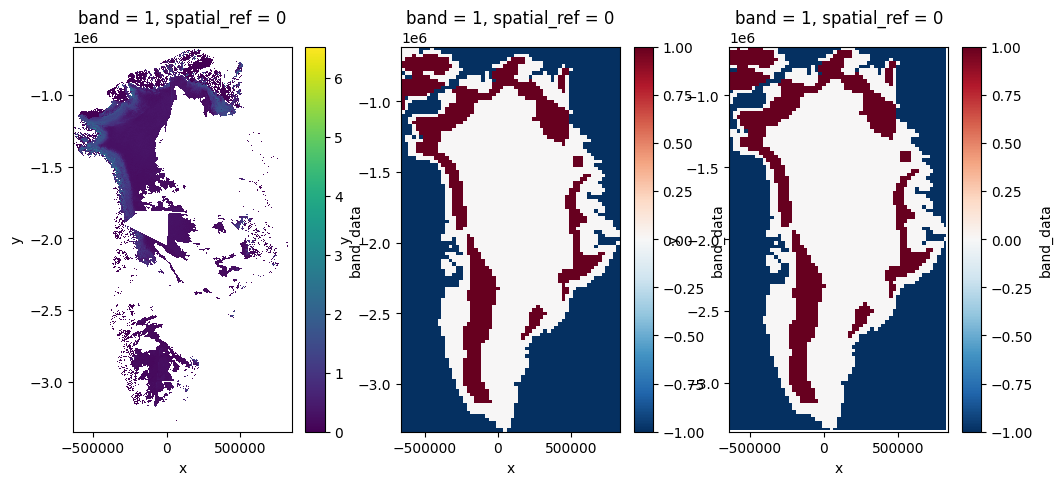

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(12,5))
data_opt.plot(ax=axes[0])
data_mw_tif.plot(ax=axes[1])
test3.plot(ax=axes[2])
plt.draw()

In [21]:
data_mw_fine_git= xarray.open_dataarray('out_new_band_git.tif')
(data_mw_fine_git==test1).sum()

<xarray.DataArray ()>
array(2268946)
Coordinates:
    spatial_ref  int64 0

In [24]:
da = xarray.DataArray(
    data=[[1, 4, 2, 9], [2, 7, 6, np.nan], [6, np.nan, 5, 8]],
    dims=("x", "y"),
    coords={"x": [0, 1, 2], "y": [10, 12, 14, 16]},
)

In [25]:
(da==da).sum()

<xarray.DataArray ()>
array(10)

In [22]:
(data_mw_fine_git==data_mw_fine_git).sum()

<xarray.DataArray 'band_data' ()>
array(3995569)
Coordinates:
    spatial_ref  int64 0

In [30]:
(test2==test2).sum()

<xarray.DataArray 'band_data' ()>
array(3893306)
Coordinates:
    spatial_ref  int64 0

In [ ]:
2268946

In [ ]:
test1

In [ ]:
# get first 2 pixels and check first new 55 pixels

In [ ]:
test1['ba']

In [19]:
#print("Compare opt and reprojected datasets \n")

print("reprojected:\n----------------")
print_raster(test1)
print("opt:\n----------------")
print_raster(data_opt)

reprojected:
----------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 222500.0
CRS: EPSG:3413

opt:
----------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: 339758.65625
CRS: EPSG:3413



## Compare results

jaccard is garbage bc is for sets ans sets are unique elements

In [19]:
data_mw_fine_git= xarray.open_dataarray('out_new_band_git.tif')

In [ ]:
# git has 0 line
# ddata has 2 line

In [21]:
# compare if coordinates are same


print("Compare opt and reprojected datasets \n")

print("reprojected manually:\n----------------")
print_raster(data_mw_fine_git)

print("reprojected with rio:\n----------------")
print_raster(data_repr_mw)

print("opt:\n----------------")
print_raster(data_opt)

Compare opt and reprojected datasets 

reprojected manually:
----------------
shape: 
   Y: 2687 
   X: 1487
resolution: (1000.0, -1000.0)
bounds: 
   minx = -637000.0 
   miny = -3349000.0 
   maxx = 850000.0 
   maxy = -662000.0
sum: -1440926.0
CRS: EPSG:3413

reprojected with rio:
----------------


NameError: name 'data_repr_mw' is not defined

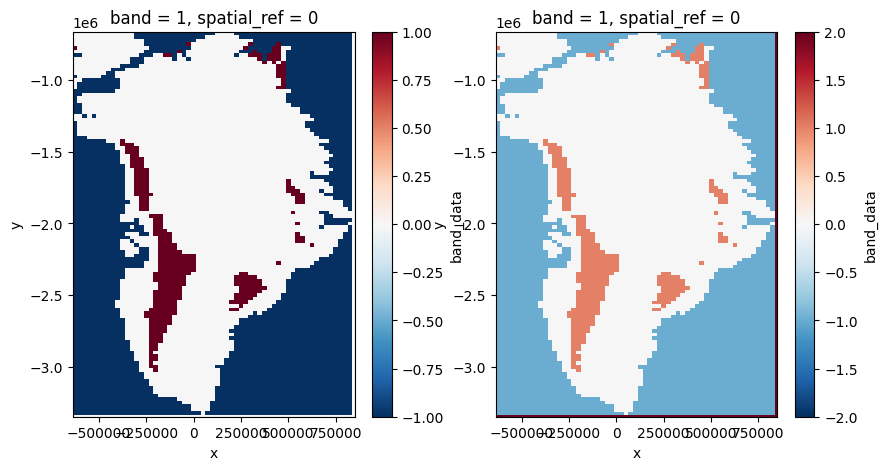

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
data_mw_fine_git.plot(ax=axes[0])
data_repr_mw.plot(ax=axes[1])
plt.draw()

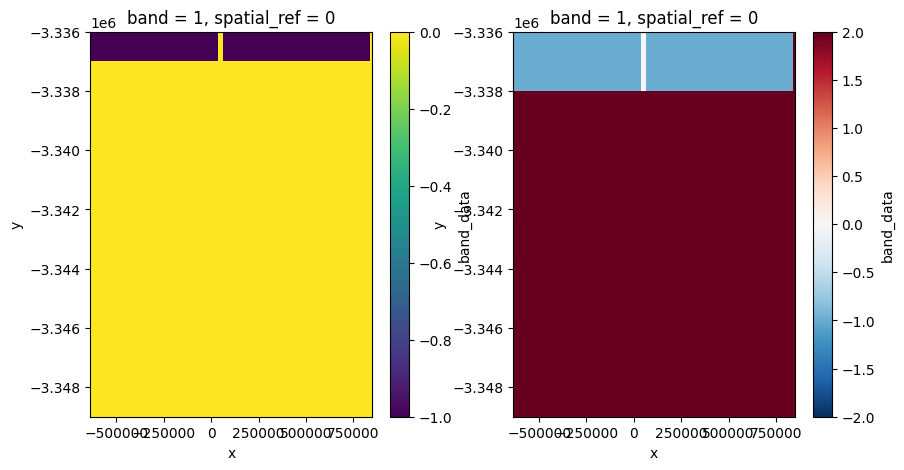

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
data_mw_fine_git[0][-13:].plot(ax=axes[0])
data_repr_mw[0][-13:].plot(ax=axes[1])
plt.draw()

In [29]:
data_mw_fine_git[0][:-100]

<xarray.DataArray 'band_data' (y: 2587, x: 1487)>
[3846869 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -6.365e+05 -6.355e+05 ... 8.485e+05 8.495e+05
  * y            (y) float64 -6.625e+05 -6.635e+05 ... -3.248e+06 -3.248e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area

In [20]:
(data_mw_fine_git==data_repr_mw).sum()

<xarray.DataArray 'band_data' ()>
array(3923592)
Coordinates:
    spatial_ref  int64 0

In [42]:
# figure out why nan lines and how to make same
# check if corners are the same
# check how much both to be cropped